To begin copy this notebook to your own drive:

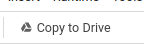


### Submission Instructions:
1. **Restart the kernel** (in the menubar, select Runtime$\rightarrow$Restart runtime)
2. **Download the notebook** (in the menubar, select File$\rightarrow$Download .ipynb)
3. **Upload the downloaded notebook (.ipynb file) to your repository**.


Make sure you fill in any place that says `YOUR CODE HERE`, and that no tests fail.  

Note: To use a GPU, do the following: Runtime$\rightarrow$Change runtime type$\rightarrow$ GPU

In [ ]:
import gdown
import nltk
gdown.download('https://drive.google.com/uc?export=download&id=1PFOG06NEsTL6VieKQjMk1oNzyzcUtiWn', 'glove.npy', quiet=False)
gdown.download('https://drive.google.com/uc?export=download&id=1-3SxpirQjmX-RCRyRjKdP2L7G_tNgp00', 'vocab.json', quiet=False)

nltk.download('punkt')

Downloading...
From: https://drive.google.com/uc?export=download&id=1PFOG06NEsTL6VieKQjMk1oNzyzcUtiWn
To: /content/glove.npy
100%|██████████| 480M/480M [00:13<00:00, 36.4MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1-3SxpirQjmX-RCRyRjKdP2L7G_tNgp00
To: /content/vocab.json
100%|██████████| 7.69M/7.69M [00:00<00:00, 78.2MB/s]
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
pip install --upgrade accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.1/219.1 kB 11.1 MB/s eta 0:00:00


In [ ]:
!pip install datasets
# !pip install transformers
!pip install transformers==4.28.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 56.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 31.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 18.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 42.3 MB/s eta 0:00

In [ ]:
import numpy as np
from datasets import load_dataset

raw_datasets = load_dataset("imdb")

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb downloaded and prepared to /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:

from nltk.tokenize import word_tokenize
import json

with open("vocab.json") as f:
  vocab = json.load(f)

def tokenize_function(example):
  sentences = [x.lower() for x in example['text']]
  tokenized_sentences = [word_tokenize(x) for x in sentences]
  tokenized_idx = [[vocab[word] if word in vocab else vocab["unk"] for word in x] for x in tokenized_sentences]
  max_size = max([len(x) for x in tokenized_idx])
  final_tokenized_idx = tokenized_idx

  return {"labels":example['label'],'input_ids':final_tokenized_idx}

In [ ]:
small_train_dataset = raw_datasets['train'].shuffle(seed=42).map(tokenize_function,batched=True)
small_eval_dataset = raw_datasets['test'].shuffle(seed=42).map(tokenize_function,batched=True)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

In [ ]:
def pad_sequence_to_length(
    sequence,
    desired_length: int,
    default_value = lambda: 0,
    padding_on_right: bool = True,
):
    sequence = list(sequence)
    # Truncates the sequence to the desired length.
    if padding_on_right:
        padded_sequence = sequence[:desired_length]
    else:
        padded_sequence = sequence[-desired_length:]
    # Continues to pad with default_value() until we reach the desired length.
    pad_length = desired_length - len(padded_sequence)
    # This just creates the default value once, so if it's a list, and if it gets mutated
    # later, it could cause subtle bugs. But the risk there is low, and this is much faster.
    values_to_pad = [default_value()] * pad_length
    if padding_on_right:
        padded_sequence = padded_sequence + values_to_pad
    else:
        padded_sequence = values_to_pad + padded_sequence
    return padded_sequence

In [ ]:
from datasets import load_metric

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits = eval_pred.predictions
    labels = eval_pred.label_ids
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

<ipython-input-9-c6aba47c7ef1>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [ ]:
from dataclasses import dataclass

@dataclass
class DataCollatorWithPadding:
  
  def __call__(self, features):
    features_dict={}
    if "labels" in features[0]:
        
      features_dict["labels"] = torch.tensor([x.pop("labels") for x in features]).long()

    input_ids = [x.pop("input_ids") for x in features]
    max_len = max(len(x) for x in input_ids)
    masks = [[1]*len(x) for x in input_ids]
    
    features_dict["input_ids"] = torch.tensor([pad_sequence_to_length(x,max_len) for x in input_ids]).long()
    features_dict["attention_masks"] = torch.tensor([pad_sequence_to_length(x,max_len) for x in masks]).long()

    return features_dict


In [ ]:
from torch import nn

import torch
from collections import OrderedDict
#Use nn.Sequential and nn.Linear for the network, and nn.CrossEntropyLoss for the loss.
#Make sure that the final layer has output dimension of size 2.
class DAN(nn.Module):
  def __init__(self, drop_out=0, num_layers = 1, activation = 'relu'):
          super().__init__()
          self.dropout = nn.Dropout(drop_out)
          self.num_labels = 2
          self.embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.load("glove.npy")))
          # YOUR CODE HERE
          embedding_size = self.embeddings.embedding_dim
          self.hidden_size = 128
          od = OrderedDict()
          for i in range(num_layers):
            if i%2==0:
              od[f'lin{i}'] = nn.Linear(embedding_size, self.hidden_size)
            else:
              od[f'lin{i}'] = nn.Linear(self.hidden_size, embedding_size)
            if(activation == 'relu'):
              od[f'{activation}{i}'] = nn.ReLU()
            elif(activation == 'tanh'):
              od[f'{activation}{i}'] = nn.Tanh()
            elif(activation == 'sigmoid'):
              od[f'{activation}{i}'] = nn.Sigmoid()
          if num_layers%2==0:
            od[f'lin{num_layers}'] = nn.Linear(embedding_size, self.num_labels)
          else:
            od[f'lin{num_layers}'] = nn.Linear(self.hidden_size, self.num_labels)
          self.classifier = nn.Sequential(od)

          # self.classifier = nn.Sequential(
          #   nn.Linear(embedding_size, self.hidden_size),
          #   nn.ReLU(),

          #   nn.Linear(self.hidden_size, self.num_labels)
          # )
          self.loss = nn.CrossEntropyLoss()         
          # END YOUR END
          


  def forward(self,input_ids,attention_masks,labels=None,**kwargs):
      # YOUR CODE HERE
      embeddings = self.embeddings(input_ids)
      avg = torch.mean(embeddings, dim=1)
      avg = self.dropout(avg)
      # END YOUR END
      res = self.classifier(avg)
      loss = self.loss(res,labels)
      return {"loss":loss,"logits":res}



In [ ]:
from transformers import Trainer
from transformers import TrainingArguments
from transformers import TrainerCallback
import matplotlib.pyplot as plt

In [ ]:
#Hint: You may want to look at https://huggingface.co/transformers/main_classes/callback.html

co = DataCollatorWithPadding()
epoch = 35
training_args = TrainingArguments("DAN",
                                  # YOUR CODE HERE
                                  num_train_epochs=epoch, #must be at least 10.
                                  per_device_train_batch_size=32,
                                  per_device_eval_batch_size=32,
                                  learning_rate=1.5e-3,
                                  # END YOUR END
                                  save_total_limit=2,
                                  log_level="error",
                                  evaluation_strategy="epoch")
model = DAN()

    


In [ ]:
class PrinterCallback(TrainerCallback):
    def __init__(self, drop_out=0, num_layers=0, activation = 'relu'):
        super().__init__()
        self.accuracies =[]
        self.dropout= drop_out
        self.num_layers = num_layers
        self.activation = activation
    def on_log(self, args, state, control, logs=None, **kwargs):
        _ = logs.pop("total_flos", None)
        if state.is_local_process_zero:
            if 'eval_accuracy' in logs:
              self.accuracies.append(logs['eval_accuracy'])
    def on_train_begin(self, args, state, control, **kwargs):
        print(f"Starting training. dropout={self.dropout}. num_layers={self.num_layers}. activation = {self.activation}")

In [ ]:
# trainer.state.log_history[1::2]

In [ ]:
drop_outs = [0,0.1,0.2,0.3,0.4,0.5]
accuracies = []
for drop_out in drop_outs:
    mycallback = PrinterCallback(drop_out,1)
    trainer = Trainer(
        model = DAN(drop_out,1),
        data_collator=co,
        args=training_args,
        callbacks = [mycallback],
        train_dataset=small_train_dataset,
        eval_dataset=small_eval_dataset,
        compute_metrics=compute_metrics,
    )
    trainer.train()
    accuracies.append(mycallback.accuracies)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Starting training. dropout=0. num_layers=1
{'loss': 0.5909, 'learning_rate': 0.0014725977347460725, 'epoch': 0.64}
{'eval_loss': 0.47068241238594055, 'eval_accuracy': 0.80036, 'eval_runtime': 12.5379, 'eval_samples_per_second': 1993.962, 'eval_steps_per_second': 62.371, 'epoch': 1.0}
{'loss': 0.4754, 'learning_rate': 0.0014451954694921446, 'epoch': 1.28}
{'loss': 0.4365, 'learning_rate': 0.0014177932042382171, 'epoch': 1.92}
{'eval_loss': 0.4268750250339508, 'eval_accuracy': 0.81212, 'eval_runtime': 12.3301, 'eval_samples_per_second': 2027.552, 'eval_steps_per_second': 63.422, 'epoch': 2.0}
{'loss': 0.4206, 'learning_rate': 0.0013903909389842894, 'epoch': 2.56}
{'eval_loss': 0.43028438091278076, 'eval_accuracy': 0.80972, 'eval_runtime': 14.1989, 'eval_samples_per_second': 1760.696, 'eval_steps_per_second': 55.075, 'epoch': 3.0}
{'loss': 0.4145, 'learning_rate': 0.0013629886737303617, 'epoch': 3.2}
{'loss': 0.4035, 'learning_rate': 0.001335586408476434, 'epoch': 3.84}
{'eval_loss': 0.40

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Starting training. dropout=0.1. num_layers=1
{'loss': 0.5967, 'learning_rate': 0.0014725977347460725, 'epoch': 0.64}
{'eval_loss': 0.48138612508773804, 'eval_accuracy': 0.7924, 'eval_runtime': 12.0573, 'eval_samples_per_second': 2073.429, 'eval_steps_per_second': 64.857, 'epoch': 1.0}
{'loss': 0.5013, 'learning_rate': 0.0014451954694921446, 'epoch': 1.28}
{'loss': 0.4694, 'learning_rate': 0.0014177932042382171, 'epoch': 1.92}
{'eval_loss': 0.43936339020729065, 'eval_accuracy': 0.808, 'eval_runtime': 12.128, 'eval_samples_per_second': 2061.349, 'eval_steps_per_second': 64.479, 'epoch': 2.0}
{'loss': 0.4582, 'learning_rate': 0.0013903909389842894, 'epoch': 2.56}
{'eval_loss': 0.4464578926563263, 'eval_accuracy': 0.79612, 'eval_runtime': 11.9448, 'eval_samples_per_second': 2092.96, 'eval_steps_per_second': 65.468, 'epoch': 3.0}
{'loss': 0.4545, 'learning_rate': 0.0013629886737303617, 'epoch': 3.2}
{'loss': 0.4437, 'learning_rate': 0.001335586408476434, 'epoch': 3.84}
{'eval_loss': 0.41734

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Starting training. dropout=0.2. num_layers=1
{'loss': 0.6065, 'learning_rate': 0.0014725977347460725, 'epoch': 0.64}
{'eval_loss': 0.5130636096000671, 'eval_accuracy': 0.76676, 'eval_runtime': 12.1164, 'eval_samples_per_second': 2063.326, 'eval_steps_per_second': 64.541, 'epoch': 1.0}
{'loss': 0.5264, 'learning_rate': 0.0014451954694921446, 'epoch': 1.28}
{'loss': 0.4963, 'learning_rate': 0.0014177932042382171, 'epoch': 1.92}
{'eval_loss': 0.4508833885192871, 'eval_accuracy': 0.80292, 'eval_runtime': 12.1002, 'eval_samples_per_second': 2066.075, 'eval_steps_per_second': 64.627, 'epoch': 2.0}
{'loss': 0.487, 'learning_rate': 0.0013903909389842894, 'epoch': 2.56}
{'eval_loss': 0.445811003446579, 'eval_accuracy': 0.802, 'eval_runtime': 12.0142, 'eval_samples_per_second': 2080.879, 'eval_steps_per_second': 65.09, 'epoch': 3.0}
{'loss': 0.481, 'learning_rate': 0.0013629886737303617, 'epoch': 3.2}
{'loss': 0.4735, 'learning_rate': 0.001335586408476434, 'epoch': 3.84}
{'eval_loss': 0.43250903

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Starting training. dropout=0.3. num_layers=1
{'loss': 0.6119, 'learning_rate': 0.0014725977347460725, 'epoch': 0.64}
{'eval_loss': 0.5244085788726807, 'eval_accuracy': 0.75476, 'eval_runtime': 12.1291, 'eval_samples_per_second': 2061.157, 'eval_steps_per_second': 64.473, 'epoch': 1.0}
{'loss': 0.5458, 'learning_rate': 0.0014451954694921446, 'epoch': 1.28}
{'loss': 0.519, 'learning_rate': 0.0014177932042382171, 'epoch': 1.92}
{'eval_loss': 0.4680182933807373, 'eval_accuracy': 0.79376, 'eval_runtime': 11.846, 'eval_samples_per_second': 2110.421, 'eval_steps_per_second': 66.014, 'epoch': 2.0}
{'loss': 0.5109, 'learning_rate': 0.0013903909389842894, 'epoch': 2.56}
{'eval_loss': 0.4610983729362488, 'eval_accuracy': 0.79784, 'eval_runtime': 11.1706, 'eval_samples_per_second': 2238.014, 'eval_steps_per_second': 70.005, 'epoch': 3.0}
{'loss': 0.5073, 'learning_rate': 0.0013629886737303617, 'epoch': 3.2}
{'loss': 0.5018, 'learning_rate': 0.001335586408476434, 'epoch': 3.84}
{'eval_loss': 0.4489

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Starting training. dropout=0.4. num_layers=1
{'loss': 0.622, 'learning_rate': 0.0014725977347460725, 'epoch': 0.64}
{'eval_loss': 0.5354913473129272, 'eval_accuracy': 0.74712, 'eval_runtime': 11.9282, 'eval_samples_per_second': 2095.869, 'eval_steps_per_second': 65.559, 'epoch': 1.0}
{'loss': 0.5661, 'learning_rate': 0.0014451954694921446, 'epoch': 1.28}
{'loss': 0.543, 'learning_rate': 0.0014177932042382171, 'epoch': 1.92}
{'eval_loss': 0.4857228994369507, 'eval_accuracy': 0.78592, 'eval_runtime': 11.8557, 'eval_samples_per_second': 2108.698, 'eval_steps_per_second': 65.96, 'epoch': 2.0}
{'loss': 0.5362, 'learning_rate': 0.0013903909389842894, 'epoch': 2.56}
{'eval_loss': 0.48284754157066345, 'eval_accuracy': 0.78572, 'eval_runtime': 12.427, 'eval_samples_per_second': 2011.75, 'eval_steps_per_second': 62.928, 'epoch': 3.0}
{'loss': 0.5328, 'learning_rate': 0.0013629886737303617, 'epoch': 3.2}
{'loss': 0.5247, 'learning_rate': 0.001335586408476434, 'epoch': 3.84}
{'eval_loss': 0.468494

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Starting training. dropout=0.5. num_layers=1
{'loss': 0.6282, 'learning_rate': 0.0014725977347460725, 'epoch': 0.64}
{'eval_loss': 0.5388059020042419, 'eval_accuracy': 0.74908, 'eval_runtime': 12.4566, 'eval_samples_per_second': 2006.975, 'eval_steps_per_second': 62.778, 'epoch': 1.0}
{'loss': 0.5826, 'learning_rate': 0.0014451954694921446, 'epoch': 1.28}
{'loss': 0.5626, 'learning_rate': 0.0014177932042382171, 'epoch': 1.92}
{'eval_loss': 0.5117366313934326, 'eval_accuracy': 0.76852, 'eval_runtime': 12.4379, 'eval_samples_per_second': 2009.979, 'eval_steps_per_second': 62.872, 'epoch': 2.0}
{'loss': 0.5589, 'learning_rate': 0.0013903909389842894, 'epoch': 2.56}
{'eval_loss': 0.5019457936286926, 'eval_accuracy': 0.77268, 'eval_runtime': 12.3231, 'eval_samples_per_second': 2028.715, 'eval_steps_per_second': 63.458, 'epoch': 3.0}
{'loss': 0.5548, 'learning_rate': 0.0013629886737303617, 'epoch': 3.2}
{'loss': 0.5486, 'learning_rate': 0.001335586408476434, 'epoch': 3.84}
{'eval_loss': 0.49

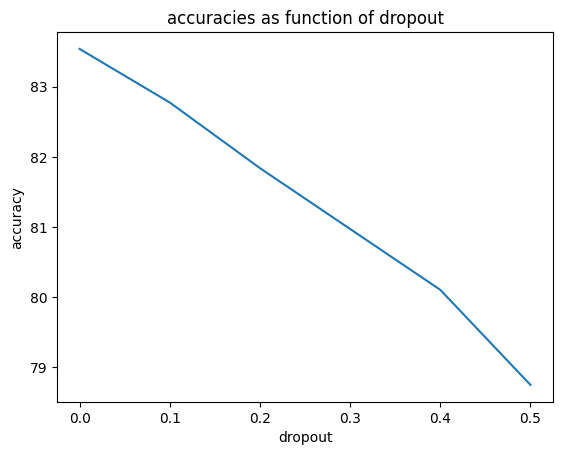

In [ ]:
acc = [x[-1]*100 for x in accuracies]
plt.plot(drop_outs, acc)
plt.xlabel("dropout")
plt.ylabel("accuracy")
plt.title("accuracies as function of dropout")
plt.show()

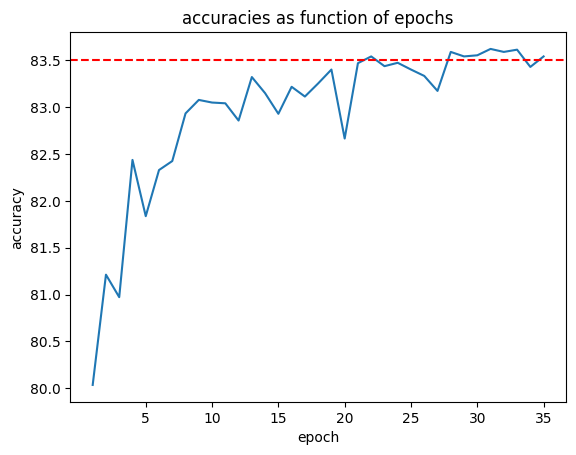

In [ ]:
epochs= range(1,epoch+1)
plt.plot(epochs, [i*100 for i in accuracies[0]])
plt.axhline(y=83.5, color='r', linestyle='--')
plt.xticks(np.arange(5,36,5))
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("accuracies as function of epochs")
plt.show()

In [ ]:
hidden_layers = [0,1,2,3]
accuracies2 = []
for hl in hidden_layers:
    mycallback = PrinterCallback(0,hl)
    trainer = Trainer(
        model = DAN(0,hl),
        data_collator=co,
        args=training_args,
        callbacks = [mycallback],
        train_dataset=small_train_dataset,
        eval_dataset=small_eval_dataset,
        compute_metrics=compute_metrics,
    )
    trainer.train()
    accuracies2.append(mycallback.accuracies)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Starting training. dropout=0. num_layers=0
{'loss': 0.6662, 'learning_rate': 0.0014725977347460725, 'epoch': 0.64}
{'eval_loss': 0.6375120878219604, 'eval_accuracy': 0.678, 'eval_runtime': 11.6745, 'eval_samples_per_second': 2141.421, 'eval_steps_per_second': 66.984, 'epoch': 1.0}
{'loss': 0.6366, 'learning_rate': 0.0014451954694921446, 'epoch': 1.28}
{'loss': 0.6162, 'learning_rate': 0.0014177932042382171, 'epoch': 1.92}
{'eval_loss': 0.6118715405464172, 'eval_accuracy': 0.70608, 'eval_runtime': 12.5062, 'eval_samples_per_second': 1999.01, 'eval_steps_per_second': 62.529, 'epoch': 2.0}
{'loss': 0.6009, 'learning_rate': 0.0013903909389842894, 'epoch': 2.56}
{'eval_loss': 0.5936909914016724, 'eval_accuracy': 0.72524, 'eval_runtime': 12.5971, 'eval_samples_per_second': 1984.577, 'eval_steps_per_second': 62.078, 'epoch': 3.0}
{'loss': 0.5924, 'learning_rate': 0.0013629886737303617, 'epoch': 3.2}
{'loss': 0.5787, 'learning_rate': 0.001335586408476434, 'epoch': 3.84}
{'eval_loss': 0.5774585

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Starting training. dropout=0. num_layers=1
{'loss': 0.5912, 'learning_rate': 0.0014725977347460725, 'epoch': 0.64}
{'eval_loss': 0.4699808657169342, 'eval_accuracy': 0.79988, 'eval_runtime': 12.2755, 'eval_samples_per_second': 2036.577, 'eval_steps_per_second': 63.704, 'epoch': 1.0}
{'loss': 0.4743, 'learning_rate': 0.0014451954694921446, 'epoch': 1.28}
{'loss': 0.4353, 'learning_rate': 0.0014177932042382171, 'epoch': 1.92}
{'eval_loss': 0.42773571610450745, 'eval_accuracy': 0.81252, 'eval_runtime': 12.2372, 'eval_samples_per_second': 2042.951, 'eval_steps_per_second': 63.903, 'epoch': 2.0}
{'loss': 0.4201, 'learning_rate': 0.0013903909389842894, 'epoch': 2.56}
{'eval_loss': 0.42925742268562317, 'eval_accuracy': 0.80968, 'eval_runtime': 12.1351, 'eval_samples_per_second': 2060.144, 'eval_steps_per_second': 64.441, 'epoch': 3.0}
{'loss': 0.4143, 'learning_rate': 0.0013629886737303617, 'epoch': 3.2}
{'loss': 0.4037, 'learning_rate': 0.001335586408476434, 'epoch': 3.84}
{'eval_loss': 0.40

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Starting training. dropout=0. num_layers=2
{'loss': 0.5243, 'learning_rate': 0.0014725977347460725, 'epoch': 0.64}
{'eval_loss': 0.39889317750930786, 'eval_accuracy': 0.82236, 'eval_runtime': 12.1932, 'eval_samples_per_second': 2050.323, 'eval_steps_per_second': 64.134, 'epoch': 1.0}
{'loss': 0.4179, 'learning_rate': 0.0014451954694921446, 'epoch': 1.28}
{'loss': 0.4032, 'learning_rate': 0.0014177932042382171, 'epoch': 1.92}
{'eval_loss': 0.3954143226146698, 'eval_accuracy': 0.82052, 'eval_runtime': 12.2516, 'eval_samples_per_second': 2040.556, 'eval_steps_per_second': 63.829, 'epoch': 2.0}
{'loss': 0.3957, 'learning_rate': 0.0013903909389842894, 'epoch': 2.56}
{'eval_loss': 0.426175594329834, 'eval_accuracy': 0.80356, 'eval_runtime': 12.2009, 'eval_samples_per_second': 2049.024, 'eval_steps_per_second': 64.093, 'epoch': 3.0}
{'loss': 0.3969, 'learning_rate': 0.0013629886737303617, 'epoch': 3.2}
{'loss': 0.3942, 'learning_rate': 0.001335586408476434, 'epoch': 3.84}
{'eval_loss': 0.3979

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Starting training. dropout=0. num_layers=3
{'loss': 0.5286, 'learning_rate': 0.0014725977347460725, 'epoch': 0.64}
{'eval_loss': 0.3985551595687866, 'eval_accuracy': 0.82416, 'eval_runtime': 11.3178, 'eval_samples_per_second': 2208.91, 'eval_steps_per_second': 69.095, 'epoch': 1.0}
{'loss': 0.4188, 'learning_rate': 0.0014451954694921446, 'epoch': 1.28}
{'loss': 0.4063, 'learning_rate': 0.0014177932042382171, 'epoch': 1.92}
{'eval_loss': 0.4322899281978607, 'eval_accuracy': 0.80128, 'eval_runtime': 12.0929, 'eval_samples_per_second': 2067.324, 'eval_steps_per_second': 64.666, 'epoch': 2.0}
{'loss': 0.4067, 'learning_rate': 0.0013903909389842894, 'epoch': 2.56}
{'eval_loss': 0.48407965898513794, 'eval_accuracy': 0.76388, 'eval_runtime': 12.1462, 'eval_samples_per_second': 2058.252, 'eval_steps_per_second': 64.382, 'epoch': 3.0}
{'loss': 0.4027, 'learning_rate': 0.0013629886737303617, 'epoch': 3.2}
{'loss': 0.3933, 'learning_rate': 0.001335586408476434, 'epoch': 3.84}
{'eval_loss': 0.4118

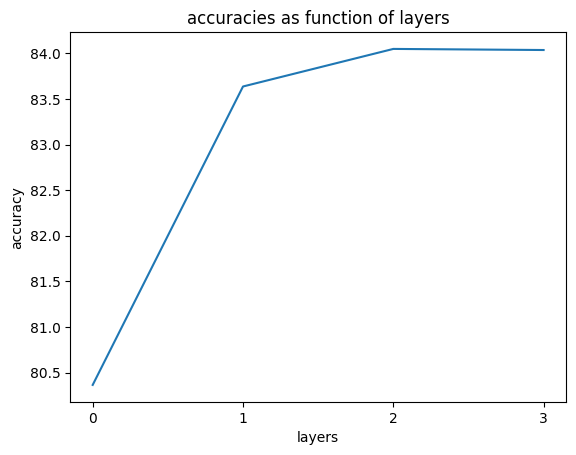

In [ ]:
acc = [x[-1]*100 for x in accuracies2]
plt.plot(hidden_layers, acc)
plt.xlabel("layers")
plt.ylabel("accuracy")
plt.xticks(np.arange(4))
plt.title("accuracies as function of layers")
plt.show()

In [ ]:
activations = ['relu', 'tanh', 'sigmoid']
accuracies3 = []
for act in activations:
    mycallback = PrinterCallback(0,1,act)
    trainer = Trainer(
        model = DAN(0,1,act),
        data_collator=co,
        args=training_args,
        callbacks = [mycallback],
        train_dataset=small_train_dataset,
        eval_dataset=small_eval_dataset,
        compute_metrics=compute_metrics,
    )
    trainer.train()
    accuracies3.append(mycallback.accuracies)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Starting training. dropout=0. num_layers=1. activation = relu
{'loss': 0.5881, 'learning_rate': 0.0014725977347460725, 'epoch': 0.64}
{'eval_loss': 0.46958643198013306, 'eval_accuracy': 0.8002, 'eval_runtime': 12.2942, 'eval_samples_per_second': 2033.472, 'eval_steps_per_second': 63.607, 'epoch': 1.0}
{'loss': 0.4731, 'learning_rate': 0.0014451954694921446, 'epoch': 1.28}
{'loss': 0.4348, 'learning_rate': 0.0014177932042382171, 'epoch': 1.92}
{'eval_loss': 0.42625078558921814, 'eval_accuracy': 0.81392, 'eval_runtime': 12.452, 'eval_samples_per_second': 2007.706, 'eval_steps_per_second': 62.801, 'epoch': 2.0}
{'loss': 0.4202, 'learning_rate': 0.0013903909389842894, 'epoch': 2.56}
{'eval_loss': 0.4307207465171814, 'eval_accuracy': 0.81004, 'eval_runtime': 11.5455, 'eval_samples_per_second': 2165.354, 'eval_steps_per_second': 67.732, 'epoch': 3.0}
{'loss': 0.4148, 'learning_rate': 0.0013629886737303617, 'epoch': 3.2}
{'loss': 0.4042, 'learning_rate': 0.001335586408476434, 'epoch': 3.84}
{

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Starting training. dropout=0. num_layers=1. activation = tanh
{'loss': 0.5533, 'learning_rate': 0.0014725977347460725, 'epoch': 0.64}
{'eval_loss': 0.4662606120109558, 'eval_accuracy': 0.79656, 'eval_runtime': 12.3674, 'eval_samples_per_second': 2021.446, 'eval_steps_per_second': 63.231, 'epoch': 1.0}
{'loss': 0.4498, 'learning_rate': 0.0014451954694921446, 'epoch': 1.28}
{'loss': 0.4295, 'learning_rate': 0.0014177932042382171, 'epoch': 1.92}
{'eval_loss': 0.4346085488796234, 'eval_accuracy': 0.80884, 'eval_runtime': 12.4323, 'eval_samples_per_second': 2010.89, 'eval_steps_per_second': 62.901, 'epoch': 2.0}
{'loss': 0.4279, 'learning_rate': 0.0013903909389842894, 'epoch': 2.56}
{'eval_loss': 0.4620128273963928, 'eval_accuracy': 0.80456, 'eval_runtime': 12.5676, 'eval_samples_per_second': 1989.245, 'eval_steps_per_second': 62.224, 'epoch': 3.0}
{'loss': 0.4276, 'learning_rate': 0.0013629886737303617, 'epoch': 3.2}
{'loss': 0.4157, 'learning_rate': 0.001335586408476434, 'epoch': 3.84}
{'

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Starting training. dropout=0. num_layers=1. activation = sigmoid
{'loss': 0.6599, 'learning_rate': 0.0014725977347460725, 'epoch': 0.64}
{'eval_loss': 0.5882313847541809, 'eval_accuracy': 0.69864, 'eval_runtime': 11.7948, 'eval_samples_per_second': 2119.583, 'eval_steps_per_second': 66.301, 'epoch': 1.0}
{'loss': 0.5839, 'learning_rate': 0.0014451954694921446, 'epoch': 1.28}
{'loss': 0.5219, 'learning_rate': 0.0014177932042382171, 'epoch': 1.92}
{'eval_loss': 0.4999411404132843, 'eval_accuracy': 0.78864, 'eval_runtime': 12.4406, 'eval_samples_per_second': 2009.556, 'eval_steps_per_second': 62.859, 'epoch': 2.0}
{'loss': 0.4879, 'learning_rate': 0.0013903909389842894, 'epoch': 2.56}
{'eval_loss': 0.475143700838089, 'eval_accuracy': 0.7968, 'eval_runtime': 12.3174, 'eval_samples_per_second': 2029.649, 'eval_steps_per_second': 63.487, 'epoch': 3.0}
{'loss': 0.4671, 'learning_rate': 0.0013629886737303617, 'epoch': 3.2}
{'loss': 0.4492, 'learning_rate': 0.001335586408476434, 'epoch': 3.84}


<Axes: >

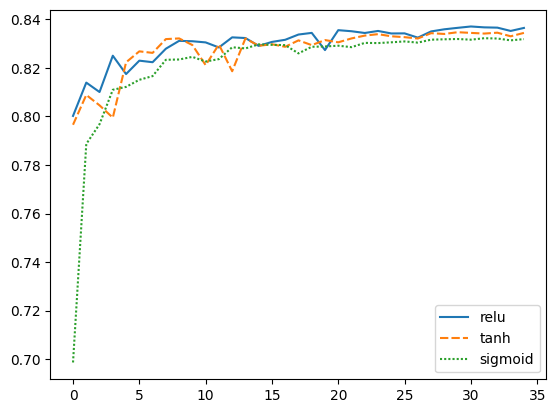

In [ ]:
import pandas as pd
import seaborn as sns
df = pd.DataFrame.from_dict({'relu':accuracies3[0], 'tanh':accuracies3[1], 'sigmoid':accuracies3[2]})
sns.lineplot(data=df)


In [ ]:
best_model = DAN(0,2,"relu")

In [ ]:
mycallback = PrinterCallback(0,2,"relu")
trainer = Trainer(
    model = best_model,
    data_collator=co,
    args=training_args,
    callbacks = [mycallback],
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
)
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Starting training. dropout=0. num_layers=2. activation = relu
{'loss': 0.5243, 'learning_rate': 0.0014725977347460725, 'epoch': 0.64}
{'eval_loss': 0.39889317750930786, 'eval_accuracy': 0.82236, 'eval_runtime': 11.6352, 'eval_samples_per_second': 2148.649, 'eval_steps_per_second': 67.21, 'epoch': 1.0}
{'loss': 0.4179, 'learning_rate': 0.0014451954694921446, 'epoch': 1.28}
{'loss': 0.4032, 'learning_rate': 0.0014177932042382171, 'epoch': 1.92}
{'eval_loss': 0.3954143226146698, 'eval_accuracy': 0.82052, 'eval_runtime': 13.027, 'eval_samples_per_second': 1919.095, 'eval_steps_per_second': 60.029, 'epoch': 2.0}
{'loss': 0.3957, 'learning_rate': 0.0013903909389842894, 'epoch': 2.56}
{'eval_loss': 0.426175594329834, 'eval_accuracy': 0.80356, 'eval_runtime': 13.6079, 'eval_samples_per_second': 1837.167, 'eval_steps_per_second': 57.467, 'epoch': 3.0}
{'loss': 0.3969, 'learning_rate': 0.0013629886737303617, 'epoch': 3.2}
{'loss': 0.3942, 'learning_rate': 0.001335586408476434, 'epoch': 3.84}
{'e

TrainOutput(global_step=27370, training_loss=0.3605000170818157, metrics={'train_runtime': 1031.6669, 'train_samples_per_second': 848.142, 'train_steps_per_second': 26.53, 'train_loss': 0.3605000170818157, 'epoch': 35.0})

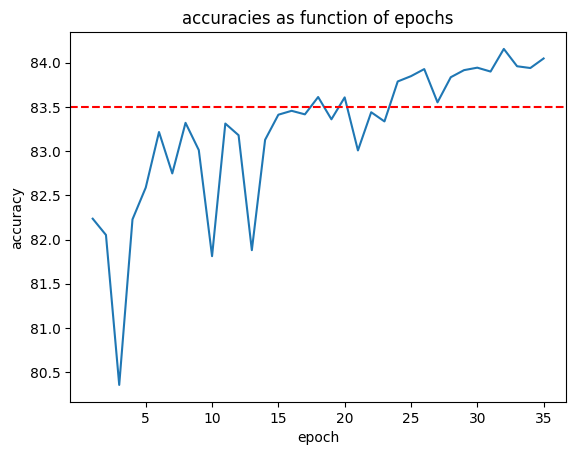

In [ ]:
epochs= range(1,epoch+1)
plt.plot(epochs, [i*100 for i in mycallback.accuracies])
plt.axhline(y=83.5, color='r', linestyle='--')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.xticks(np.arange(5,36,5))
plt.title("accuracies as function of epochs")
plt.show()

In [ ]:
predictions = trainer.predict(small_eval_dataset)
predicted_labels = predictions.predictions.argmax(axis=1)
ground_truth_labels = predictions.label_ids
wrong_indices = (predicted_labels != ground_truth_labels).nonzero()

In [ ]:
wrong_samples = [{small_eval_dataset[int(index)]['label']:small_eval_dataset[int(index)]['text']} for index in wrong_indices[0][:30]]

In [ ]:
correct_samples = [{small_eval_dataset[int(index)]['label']:small_eval_dataset[int(index)]['text']} for index in range(2500) if index not in wrong_indices[0]][:30]

In [ ]:
wrong_samples

[{1: "This is the latest entry in the long series of films with the French agent, O.S.S. 117 (the French answer to James Bond). The series was launched in the early 1950's, and spawned at least eight films (none of which was ever released in the U.S.). 'O.S.S.117:Cairo,Nest Of Spies' is a breezy little comedy that should not...repeat NOT, be taken too seriously. Our protagonist finds himself in the middle of a spy chase in Egypt (with Morroco doing stand in for Egypt) to find out about a long lost friend. What follows is the standard James Bond/Inspector Cloussou kind of antics. Although our man is something of an overt xenophobe,sexist,homophobe, it's treated as pure farce (as I said, don't take it too seriously). Although there is a bit of rough language & cartoon violence, it's basically okay for older kids (ages 12 & up). As previously stated in the subject line, just sit back,pass the popcorn & just enjoy."},
 {1: 'This is a really sad, and touching movie! It deals with the subjec

In [ ]:
correct_samples

[{1: "<br /><br />When I unsuspectedly rented A Thousand Acres, I thought I was in for an entertaining King Lear story and of course Michelle Pfeiffer was in it, so what could go wrong?<br /><br />Very quickly, however, I realized that this story was about A Thousand Other Things besides just Acres. I started crying and couldn't stop until long after the movie ended. Thank you Jane, Laura and Jocelyn, for bringing us such a wonderfully subtle and compassionate movie! Thank you cast, for being involved and portraying the characters with such depth and gentleness!<br /><br />I recognized the Angry sister; the Runaway sister and the sister in Denial. I recognized the Abusive Husband and why he was there and then the Father, oh oh the Father... all superbly played. I also recognized myself and this movie was an eye-opener, a relief, a chance to face my OWN truth and finally doing something about it. I truly hope A Thousand Acres has had the same effect on some others out there.<br /><br />